In [21]:
import json
import csv
import os
import shutil
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as timg

In [44]:
CLASS_NAMES = [
    "Combat",
    "DestroyedBuildings",
    "Fire",
    "Humanitarian Aid and rehabilitation",
    "Military vehicles and weapons",
]

In [45]:
import cv2

# URL of the video stream
stream_url = "http://10.53.32.99:8080/video"

# Open the video stream
cap = cv2.VideoCapture(stream_url)
if not cap.isOpened():
    print("Error: Unable to open video stream.")
    exit()

# Set desired dimensions for display
display_width = 640
display_height = 480

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    # Resize the frame for display only (capture retains original resolution)
    frame_resized = cv2.resize(frame, (display_width, display_height))
    
    # Show the resized video stream
    cv2.imshow("Video Stream", frame_resized)
    
    key = cv2.waitKey(1) & 0xFF
    if key == ord('c'):
        # Save the original frame to disk
        cv2.imwrite("captured_frame.jpg",frame)
        print("Frame captured and saved as captured_frame.jpg")
    elif key == 27:  # Press 'ESC' key to exit
        break

cap.release()
cv2.destroyAllWindows()


Frame captured and saved as captured_frame.jpg


In [50]:
output_dir="extracted_images"
input_image_path="captured_frame.jpg"

In [51]:
if not os.path.exists(output_dir):
        os.makedirs(output_dir)

In [52]:
image = cv2.imread(input_image_path)
original_image = image.copy()  # Keep a copy of the original image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for display

# Convert to HSV color space for better color detection
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# Define multiple yellow ranges to account for variations
yellow_ranges = [
    (np.array([15, 50, 70]), np.array([45, 255, 255])),
    (np.array([20, 100, 100]), np.array([35, 255, 255])),
    (np.array([15, 30, 150]), np.array([45, 150, 255]))
]

# Create a combined mask for all yellow ranges
combined_mask = np.zeros_like(hsv[:, :, 0])
for lower_yellow, upper_yellow in yellow_ranges:
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    combined_mask = cv2.bitwise_or(combined_mask, mask)

# Apply morphological operations
kernel = np.ones((3, 3), np.uint8)
mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.dilate(mask, kernel, iterations=2)

# Edge detection
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray, 50, 150)
edges = cv2.dilate(edges, kernel, iterations=1)

# Combine edges with color mask
combined = cv2.bitwise_and(edges, mask)

# Find contours
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
if len(contours) > 5:
    contours = contours[:10]

output = image.copy()
extracted_images = []
extracted_paths = []

# CSV file path
csv_filename = os.path.join(output_dir, "coordinates.csv")

# Save coordinates to CSV
with open(csv_filename, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Image Name", "X", "Y", "Width", "Height"])
    
    for idx, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        
        # Updated size filter
        if w > 100 and h > 100:
            padding = 5
            inner_x = x + padding
            inner_y = y + padding
            inner_w = w - 2 * padding
            inner_h = h - 2 * padding
            
            if inner_w > 0 and inner_h > 0:
                extracted_img = image[inner_y:inner_y + inner_h, inner_x:inner_x + inner_w]
                extracted_images.append((extracted_img, (x, y, w, h)))
                
                img_filename = f"extracted_{idx + 1}.png"
                img_path = os.path.join(output_dir, img_filename)
                cv2.imwrite(img_path, cv2.cvtColor(extracted_img, cv2.COLOR_RGB2BGR))
                extracted_paths.append(img_path)
                
                writer.writerow([img_filename, x, y, w, h])
                
                cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)

# Grid-based fallback for visualization only (no saving)
if len(extracted_images) != 5:
    h, w = image.shape[:2]
    rows, cols = 3, 2
    cell_height = h // rows
    cell_width = w // cols
    
    grid_positions = [
        (0, 0), (0, 1),
        (1, 0), (1, 1),
        (2, 1)
    ]
    
    for idx, (row, col) in enumerate(grid_positions):
        margin = 20
        x1 = col * cell_width + margin
        y1 = row * cell_height + margin
        x2 = (col + 1) * cell_width - margin
        y2 = (row + 1) * cell_height - margin
        
        # Check size requirement
        if (x2 - x1) > 100 and (y2 - y1) > 100:
            # Only draw rectangle for visualization (no saving)
            cv2.rectangle(output, (x1, y1), (x2, y2), (255, 0, 0), 3)

print(f"Extracted {len(extracted_images)} images saved in '{output_dir}'.")


Extracted 1 images saved in 'extracted_images'.


In [53]:
def load_character_config(config_file="character_config.json"):
    """Load character configuration from JSON file"""
    with open(config_file, 'r') as f:
        return json.load(f)

In [54]:
def load_and_preprocess(image_path, target_size=(224, 224)):
    """Load and preprocess an image for model prediction"""
    try:
        img = timg.load_img(image_path, target_size=target_size)
        x = timg.img_to_array(img)
        x = np.expand_dims(x, axis=0) 
        images = np.vstack([x])
        return images
    except Exception as e:
        print(f"Error processing {os.path.basename(image_path)}: {str(e)}")
        return None

In [55]:
def assign_character(x, y, char_config):
    """Assign a character based on coordinates"""
    try:
        x = int(x)
        y = int(y)
    except ValueError:
        return char_config["default_character"]
    
    for assignment in char_config["character_assignments"]:
        if x == assignment["x"] and y == assignment["y"]:
            return assignment["character"]
    
    return char_config["default_character"]

In [56]:
model_path="Finalmodel123.h5",
config_file="character_config.json",
output_csv="predictions_with_characters.csv"

In [57]:
def main(
    captured_image_path="captured_image.jpg",
    model_path="Finalmodel123.h5",
    config_file="character_config.json",
    output_csv="predictions_with_characters.csv"
):
    """Main pipeline function for image extraction and classification"""
    # Validate input image
    # if not os.path.exists(captured_image_path):
    #     print(f"Error: Input image not found at {captured_image_path}")
    #     return

    # # --------------------------
    # # Handle extraction folder
    # # --------------------------
    # extraction_dir = "extracted_images"
    # coords_csv_path = os.path.join(extraction_dir, "coordinates.csv")
    
    # # Clean existing extraction results if folder exists
    # if os.path.exists(extraction_dir):
    #     print(f"Cleaning existing extraction directory: {extraction_dir}")
    #     shutil.rmtree(extraction_dir)
    
    # # Create fresh extraction directory
    # os.makedirs(extraction_dir, exist_ok=True)

    # # --------------------------
    # # Extract rectangles using our integrated function
    # # --------------------------
    # print("Extracting rectangles...")
    # try:
    #     # Call our integrated extraction function
    #     extracted_paths = extracted_images(
    #         input_image_path=captured_image_path,
    #         output_dir=extraction_dir
    #     )
    #     print(f"Extracted {len(extracted_paths)} images")
    # except Exception as e:
    #     print(f"Extraction failed: {str(e)}")
    #     return

    # # Validate coordinates CSV
    # if not os.path.exists(coords_csv_path):
    #     print(f"ERROR: Coordinates CSV not found at {coords_csv_path}")
    #     return

    # --------------------------
    # Process coordinates
    # --------------------------
    try:
        # Read the coordinates CSV with the correct column names
        coordinates_data = []
        with open(coords_csv_path, 'r', newline='') as f:
            reader = csv.reader(f)
            header = next(reader)  # Skip header
            for row in reader:
                coordinates_data.append({
                    'filename': row[0],
                    'x': row[1],
                    'y': row[2],
                    'width': row[3],
                    'height': row[4]
                })
    except Exception as e:
        print(f"Error reading coordinates CSV: {str(e)}")
        return

    # --------------------------
    # Load model & classify
    # --------------------------
    try:
        print("Loading model...")
        model = load_model(model_path)
        print("Model loaded successfully")
    except Exception as e:
        print(f"Model loading failed: {str(e)}")
        return

    char_config = load_character_config(config_file)
    results = []

    for img_path in extracted_paths:
        if not os.path.exists(img_path):
            print(f"Missing extracted image: {img_path}")
            continue

        filename = os.path.basename(img_path)
        entry = next((item for item in coordinates_data if item['filename'] == filename), None)
        if not entry:
            print(f"No coordinates found for {filename}")
            continue

        # Process image
        processed_img = load_and_preprocess(img_path)
        if processed_img is None:
            continue

        # Make prediction
        try:
            pred = model.predict(processed_img)
            class_probs = {cls: float(pred[0][i]) for i, cls in enumerate(CLASS_NAMES)}
            predicted_class = CLASS_NAMES[np.argmax(pred)]

            results.append({
                "filename": filename,
                "x": entry['x'],
                "y": entry['y'],
                "width": entry['width'],
                "height": entry['height'],
                "character": assign_character(entry['x'], entry['y'], char_config),
                "prediction": predicted_class,
                **class_probs
            })
        except Exception as e:
            print(f"Prediction failed for {filename}: {str(e)}")

    # Save results
    if results:
        df = pd.DataFrame(results)
        columns = ["filename", "x", "y", "width", "height", "character", "prediction"] + CLASS_NAMES
        df[columns].to_csv(output_csv, index=False)
        print(f"Saved {len(df)} predictions to {output_csv}")
    else:
        print("No valid predictions to save")

# Example of character_config.json format for reference:
# {
#     "default_character": "Unknown",
#     "character_assignments": [
#         {"x": 100, "y": 150, "character": "Character1"},
#         {"x": 300, "y": 200, "character": "Character2"},
#         {"x": 500, "y": 250, "character": "Character3"}
#     ]
# }

if __name__ == "__main__":
    # Suppress TensorFlow warnings
    os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
    main()

Loading model...


Model loaded successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Saved 1 predictions to predictions_with_characters.csv


In [58]:
import pandas as pd 
df =pd.read_csv("predictions_with_characters.csv")

In [59]:
print(df.columns)

Index(['filename', 'x', 'y', 'width', 'height', 'character', 'prediction',
       'Combat', 'DestroyedBuildings', 'Fire',
       'Humanitarian Aid and rehabilitation', 'Military vehicles and weapons'],
      dtype='object')


In [60]:
# Assuming df is your DataFrame
df = df.iloc[:, :7] 
df.drop(["character"], axis=1, inplace=True)


In [61]:
df.head()

,filename,x,y,width,height,prediction
0,extracted_1.png,337,248,218,130,Humanitarian Aid and rehabilitation


In [63]:
# Initialize the result list with 'S'
result = ['S']

# Define coordinate ranges for each character
# Example: {'A': (x_min, x_max, y_min, y_max), ...}
coord_ranges = {
    'A': (300, 350, 200, 250),
    'B': (620, 645, 620, 650),
    'C': (1110, 1400, 600, 650),
    'D': (800, 850, 200, 250),
    'E': (1235, 1265, 220, 250)
}

# Iterate through DataFrame rows
for _, row in df.iterrows():
    x, y = row['x'], row['y']
    found = False
    for char, (x_min, x_max, y_min, y_max) in coord_ranges.items():
        if x_min <= x <= x_max and y_min <= y <= y_max:
            result.append(char)
            found = True
            break
    if not found:
        result.append('Unknown')  # Or any default value

# Now result contains 'S', followed by matched characters per row
print(result)


['S', 'A']


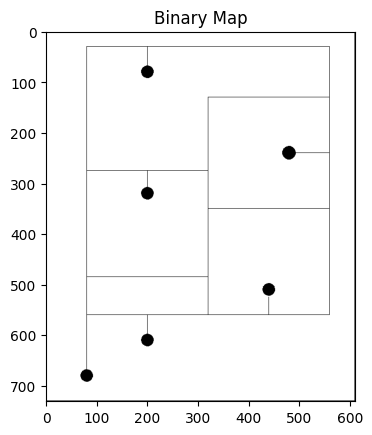

All nodes are walkable!

Processing segment S → A
Initial direction: north
Commands: ['right0', 'right0', 'north']


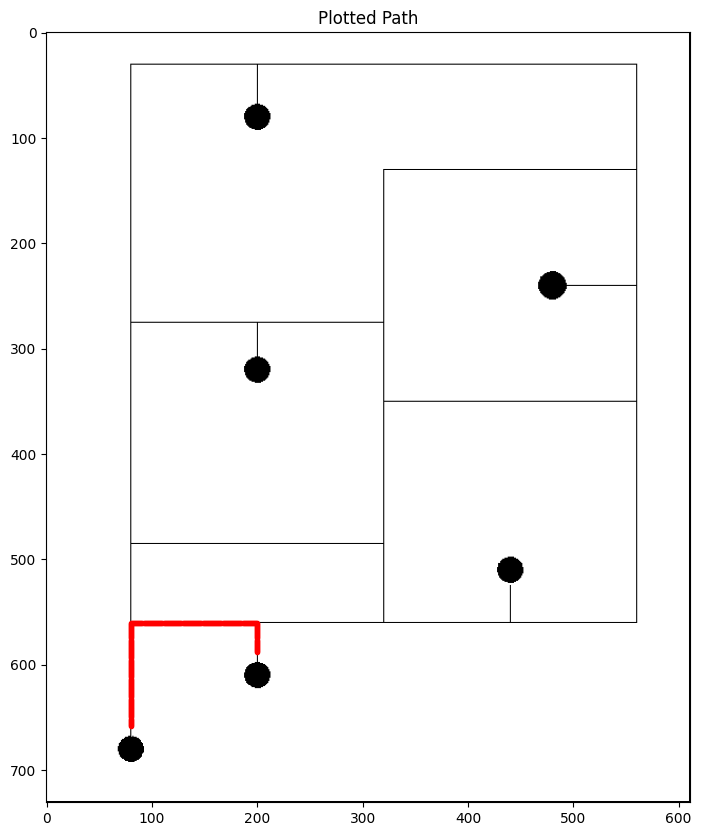


Processing return segment A → S
Initial direction: north
Commands: ['left0', 'left0', 'north']


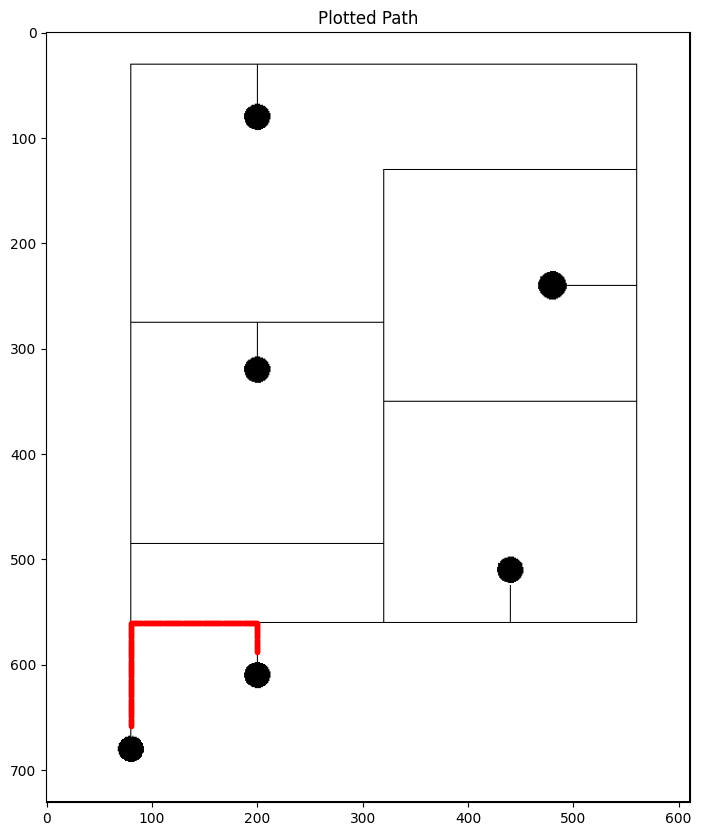


All Segment Commands:
StoA: ['right0', 'right0', 'north']
A_to_S: ['left0', 'left0', 'north']

Combined Navigation Commands:
['right0', 'right0', 'north', 'left0', 'left0', 'north']


In [64]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import heapq
import operator

# === Load and Process Map Image ===
image_path = "fin1.jpg"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
_, binary_map = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
binary_map = binary_map / 255
binary_map = binary_map.astype(np.uint8)

plt.imshow(binary_map, cmap="gray")
plt.title("Binary Map")
plt.show()

# === Define Predefined Nodes ===
point_dict = {
    "S": (80, 658),
    "A": (200, 588),
    "B": (440, 536),
    "C": (504, 240),
    "D": (200, 297),
    "E": (200, 51),
}
nodes = [point_dict[k] for k in ["S", "A", "B", "C", "D", "E"]]


# === Check if All Nodes are Walkable ===
def is_walkable(node, binary_map):
    x, y = node
    return binary_map[y, x] == 0


for node in nodes:
    if not is_walkable(node, binary_map):
        print(f"Node {node} is not walkable!")
        exit(1)
print("All nodes are walkable!")


# === A* Search ===
def astar_search(binary_map, start, end):
    rows, cols = binary_map.shape
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]

    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: abs(start[0] - end[0]) + abs(start[1] - end[1])}

    while open_set:
        _, current = heapq.heappop(open_set)
        if current == end:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]

        for dx, dy in directions:
            neighbor = (current[0] + dx, current[1] + dy)
            if not (0 <= neighbor[0] < cols and 0 <= neighbor[1] < rows):
                continue
            if binary_map[neighbor[1]][neighbor[0]] == 1:
                continue

            temp_g_score = g_score[current] + 1
            if neighbor not in g_score or temp_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = temp_g_score
                f_score[neighbor] = (
                    temp_g_score + abs(neighbor[0] - end[0]) + abs(neighbor[1] - end[1])
                )
                heapq.heappush(open_set, (f_score[neighbor], neighbor))

    print(f"No path found from {start} to {end}")
    return []


# === Plot Path ===
def plot_path(image, path):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap="gray")
    x_coords, y_coords = zip(*path)
    plt.plot(x_coords, y_coords, marker="o", color="red", markersize=3, linewidth=2)
    plt.title("Plotted Path")
    plt.show()


# === Process Path Segment into Movement Commands ===
def process_path_segment(binary_map, path):
    directions = {(-1, 0): "west", (1, 0): "east", (0, -1): "north", (0, 1): "south"}

    commands = []
    right_count, left_count = 0, 0
    direction = directions[(path[1][0] - path[0][0], path[1][1] - path[0][1])]
    print(f"Initial direction: {direction}")

    for i in range(1, len(path)):
        x, y = path[i]
        if direction == "north":
            if (binary_map[y][x - 1] == 0) and ((x - 1, y) in path):
                direction = "west"
                commands.append(f"left{left_count}")
                right_count, left_count = 0, 0
            elif (binary_map[y][x + 1] == 0) and ((x + 1, y) in path):
                direction = "east"
                commands.append(f"right{right_count}")
                right_count, left_count = 0, 0
            else:
                if binary_map[y][x - 1] == 0:
                    left_count += 1
                elif binary_map[y][x + 1] == 0:
                    right_count += 1
        elif direction == "south":
            if (binary_map[y][x + 1] == 0) and ((x + 1, y) in path):
                direction = "east"
                commands.append(f"left{left_count}")
                right_count, left_count = 0, 0
            elif (binary_map[y][x - 1] == 0) and ((x - 1, y) in path):
                direction = "west"
                commands.append(f"right{right_count}")
                right_count, left_count = 0, 0
            else:
                if binary_map[y][x + 1] == 0:
                    left_count += 1
                elif binary_map[y][x - 1] == 0:
                    right_count += 1
        elif direction == "west":
            if (binary_map[y + 1][x] == 0) and ((x, y + 1) in path):
                direction = "south"
                commands.append(f"left{left_count}")
                right_count, left_count = 0, 0
            elif (binary_map[y - 1][x] == 0) and ((x, y - 1) in path):
                direction = "north"
                commands.append(f"right{right_count}")
                right_count, left_count = 0, 0
            else:
                if binary_map[y + 1][x] == 0:
                    left_count += 1
                elif binary_map[y - 1][x] == 0:
                    right_count += 1
        elif direction == "east":
            if (binary_map[y - 1][x] == 0) and ((x, y - 1) in path):
                direction = "north"
                commands.append(f"left{left_count}")
                right_count, left_count = 0, 0
            elif (binary_map[y + 1][x] == 0) and ((x, y + 1) in path):
                direction = "south"
                commands.append(f"right{right_count}")
                right_count, left_count = 0, 0
            else:
                if binary_map[y - 1][x] == 0:
                    left_count += 1
                elif binary_map[y + 1][x] == 0:
                    right_count += 1

    res = tuple(map(operator.sub, path[-1], path[-2]))
    if directions[res] == "south":
        commands.append("north")
    elif directions[res] == "north":
        commands.append("south")
    elif directions[res] == "east":
        commands.append("west")
    elif directions[res] == "west":
        commands.append("east")

    print("Commands:", commands)
    return commands


# === Run A* and Generate Commands ===
names = result
all_commands = {}

for i in range(len(names) - 1):
    start = names[i]
    end = names[i + 1]
    segment = astar_search(binary_map, point_dict[start], point_dict[end])
    if segment:
        print(f"\nProcessing segment {start} → {end}")
        commands = process_path_segment(binary_map, segment)
        all_commands[f"{start}to{end}"] = commands
        plot_path(binary_map, segment)

# === Return to Start ===
return_segment = astar_search(binary_map, point_dict[names[-1]], point_dict["S"])
if return_segment:
    print(f"\nProcessing return segment {names[-1]} → S")
    commands = process_path_segment(binary_map, return_segment)
    all_commands[f"{names[-1]}_to_S"] = commands
    plot_path(binary_map, return_segment)

# === Final Output ===
print("\nAll Segment Commands:")
for segment, cmds in all_commands.items():
    print(f"{segment}: {cmds}")

combined_commands = []
for cmds in all_commands.values():
    combined_commands.extend(cmds)

print("\nCombined Navigation Commands:")
print(combined_commands)
